# Simulation Analsysis
In this interactive Notebook the simulation algorithm is analyzed on how many times a match should be sampled for a representative sample of the Poisson-Binomial Distribution. The resulting distribution vectors are assessed over different notions of distance to the exact distribution.

In [1]:
# Import the libraries used in the notebook
import pandas as pd
from matplotlib import pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import scipy

In [2]:
xg_df = pd.read_pickle('possession_xGs.pkl')

In [3]:
xg_df.head()

,match_id,possession,team_id,possession_xg
0,7298,4,971,0.018856
1,7298,15,971,0.041846
2,7298,16,971,0.201622
3,7298,41,971,0.118626
4,7298,50,971,0.025282


In [4]:
# This is the DP algorithm which will be used to calculate the exact distribution in a numerically stable way
def dp(p_is):
    n = len(p_is)
    p_k = [1] + [0]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = p_is[i-1]*p_k[c-1]
            p_k[c-1] -= inc
            p_k[c] += inc
    return p_k

# This is the simulation algorithm. Apart from the goal probabilities for a posession it also takes in a positive integer n, which is the amount of samples of the match.
def simulation(p_is, n):
    amnts = [0]*(len(p_is)+1)
    for _ in range(n):
        goal_amnt = sum([int(random.random() < p_i) for p_i in p_is])
        amnts[goal_amnt] += 1
    return [amnt/n for amnt in amnts]

In [5]:
N = 2000 # Maximum number of simulations
REPEAT = 150 # Number of runs for a single match
cosine_similarities = []
max_abs_diffs = []
jensen_shannon_divergences = []
number_of_xgs = []
simulation_times = []
for i in tqdm(range(1, N+1)):
    chosen_match = np.random.choice(xg_df['match_id'].unique())
    chosen_team = np.random.choice(xg_df[xg_df['match_id'] == chosen_match]['team_id'].unique())
    p_is = xg_df[(xg_df['match_id'] == chosen_match) & (xg_df['team_id'] == chosen_team)]['possession_xg'].to_list()
    number_of_xgs.append(len(p_is))
    exact_distribution = np.array(dp(p_is))
    simulated_distributions = []
    for _ in range(REPEAT):
        simulated_distributions.append(np.array(simulation(p_is, i)))
    cos_agg = np.zeros(REPEAT)
    max_abs_agg = np.zeros(REPEAT)
    jens_shan_agg = np.zeros(REPEAT)
    for i, sim_distribution in enumerate(simulated_distributions):
        cos_agg[i] = scipy.spatial.distance.cosine(exact_distribution, sim_distribution)
        max_abs_agg[i] = np.max(np.absolute(exact_distribution - sim_distribution))
        jens_shan_agg[i] = scipy.spatial.distance.jensenshannon(exact_distribution, sim_distribution)
    cosine_similarities.append(np.average(cos_agg))
    max_abs_diffs.append(np.average(max_abs_agg))
    jensen_shannon_divergences.append(np.average(jens_shan_agg))

100%|██████████| 2000/2000 [07:59<00:00,  4.18it/s]


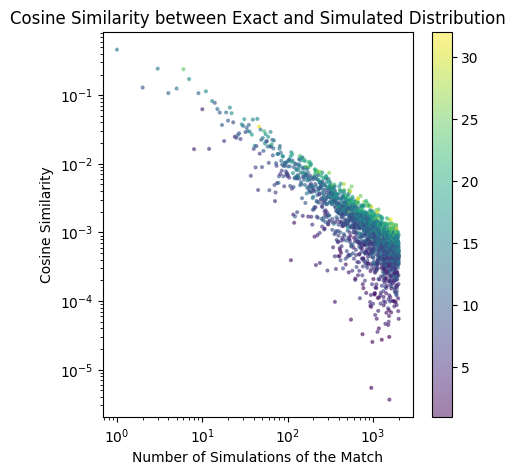

In [6]:
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.xscale('log')
plt.scatter(range(1, N+1), cosine_similarities, c=number_of_xgs, s=4, alpha=0.5)
plt.colorbar()
plt.title('Cosine Difference between Exact and Simulated Distribution')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Cosine Difference')
plt.show()

<Figure size 640x480 with 0 Axes>

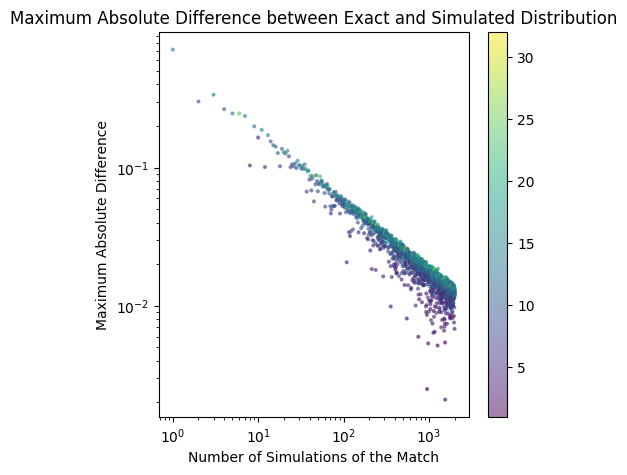

In [7]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.xscale('log')
plt.scatter(range(1, N+1), max_abs_diffs, c=number_of_xgs, s=4, alpha=0.5)
plt.colorbar()
plt.title('Maximum Absolute Difference between Exact and Simulated Distribution')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Maximum Absolute Difference')
plt.show()

<Figure size 640x480 with 0 Axes>

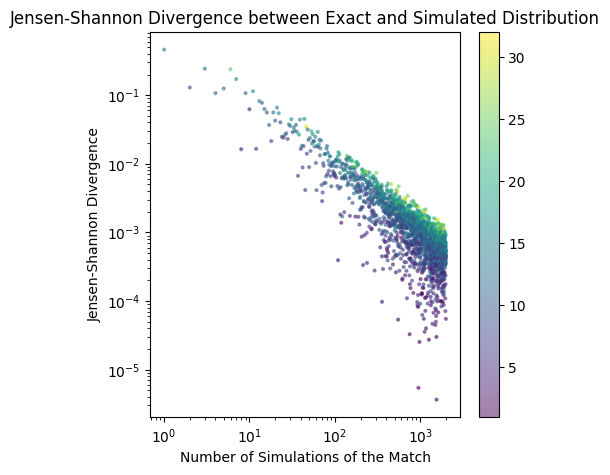

In [8]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.xscale('log')
plt.scatter(range(1, N+1), cosine_similarities, c=number_of_xgs, s=4, alpha=0.5)
plt.colorbar()
plt.title('Jensen-Shannon Divergence between Exact and Simulated Distribution')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Jensen-Shannon Divergence')
plt.show()